In [1]:
pip install pymc3

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

# Import dataset
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Set constants and seed
NUM_SAMPLES, NUM_VARS = data.shape
SEED = 999
np.random.seed(SEED)

# Preview
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [17]:
# Make sure there are no missing values
assert not data.isnull().values.any()

# Index binary variables 
is_binary = data.isin([0,1]).all().values

# Split variable types and keep record of var names
X_bin = data.iloc[:, is_binary]
X_quant = data.iloc[:, ~is_binary]

# Store var names as lists
bin_names = data.columns[is_binary].tolist()
quant_names = data.columns[~is_binary].tolist()

# Box-Cox transform of quant variables, then standardize
X_quant = X_quant.apply(lambda x: stats.boxcox(x)[0])
X_quant = StandardScaler().fit_transform(X_quant)

# Look into proportions in binary variables
print('Proportions in binary variables:\n', X_bin.mean())

Proportions in binary variables:
 anaemia                0.431438
diabetes               0.418060
high_blood_pressure    0.351171
sex                    0.648829
smoking                0.321070
DEATH_EVENT            0.321070
dtype: float64


<AxesSubplot:>

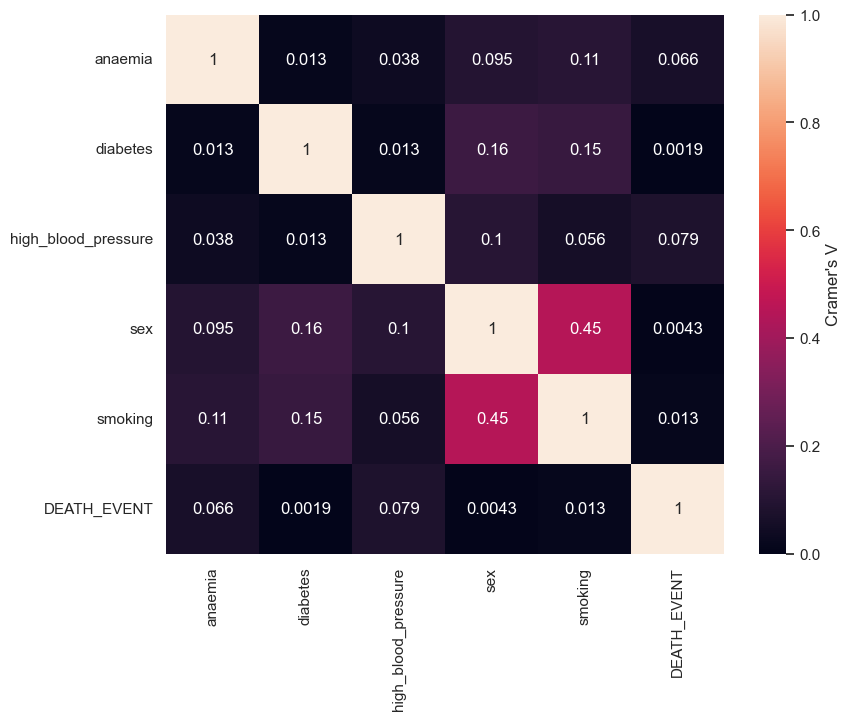

In [18]:
# NOTE: This function should only take binary variables
def cramers_v(x, y):
    # Confusion matrix
    conf_matrix = pd.crosstab(x, y)
    # Compute chi-squared w/o Yates' continuity correction
    chi2 = stats.chi2_contingency(conf_matrix, correction=False)[0]
    n = sum(conf_matrix.sum())
    # With binary variables we have V = np.sqrt(chi2 / n)
    return np.sqrt(chi2 / n)

# Create and populate correlation matrix
corr_bin = np.eye(X_bin.shape[1])
for r in range(X_bin.shape[1]):
    for c in range(X_bin.shape[1]):
        corr_bin[r,c] = cramers_v(X_bin.iloc[:,r], X_bin.iloc[:,c])

# Plot correlation matrix
sns.set(rc={'figure.figsize':(9, 7)})
sns.heatmap(corr_bin, vmin=0, vmax=1, annot=True,
            cbar_kws={'label': "Cramer's V"},
            xticklabels=bin_names, yticklabels=bin_names)

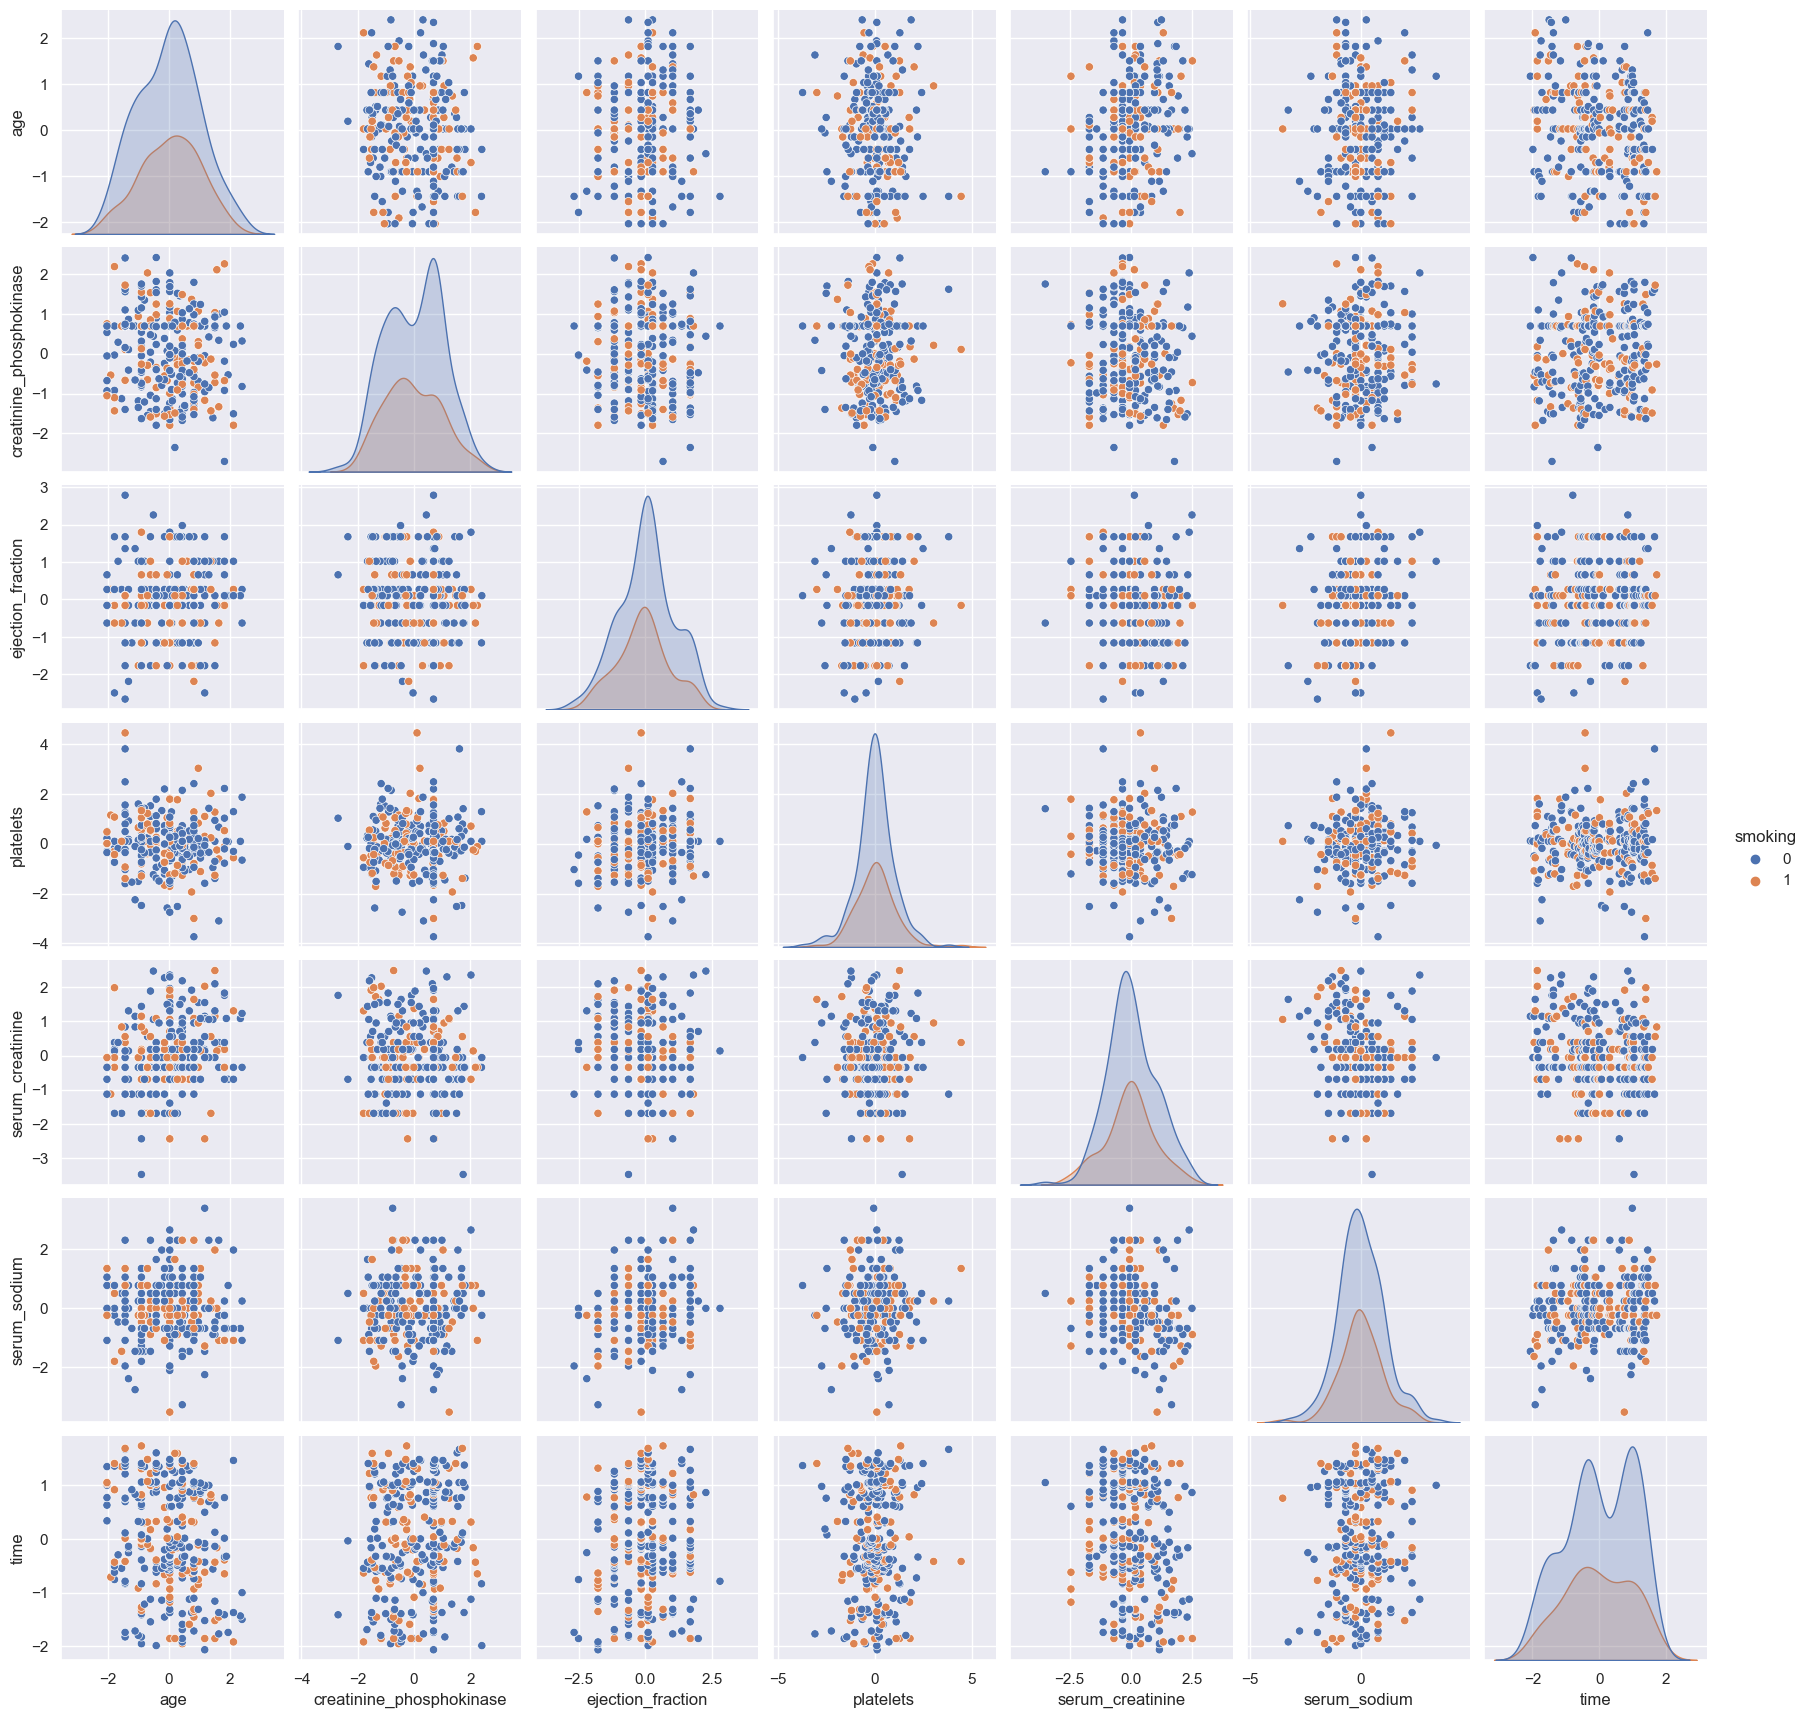

In [19]:
# Create dataframe to enable pairplot
data_pairplot = pd.DataFrame(X_quant, columns=quant_names)
data_pairplot['smoking'] = X_bin.smoking

# Pairplot (quantitative variables)
sns.pairplot(data=data_pairplot, hue='smoking')

Text(0, 0.5, 'PC2 (17.39%)')

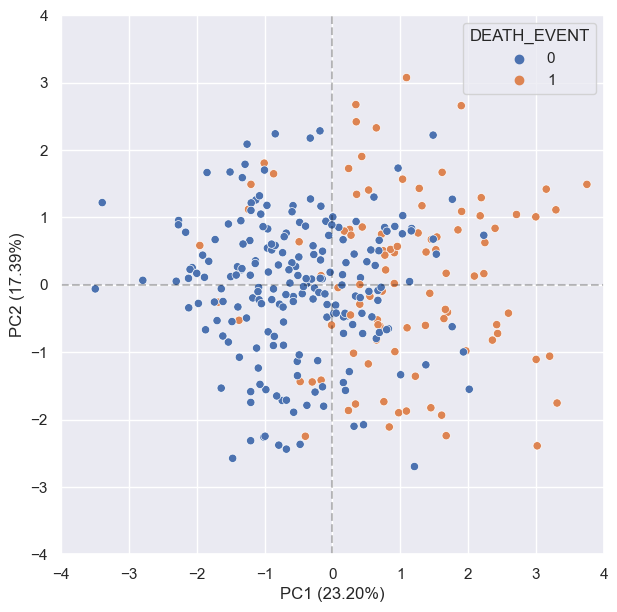

In [20]:
# Fit PCA
pca_model = PCA(n_components=2).fit(X_quant)
explained_var = pca_model.explained_variance_ratio_*100
scores = pd.DataFrame(pca_model.transform(X_quant), columns=['PC1','PC2'])
scores['DEATH_EVENT'] = X_bin.DEATH_EVENT

# PC1-2 scatterplot
sns.set(rc={'figure.figsize':(7, 7)})
sns.scatterplot(x='PC1', y='PC2', data=scores,
               hue='DEATH_EVENT')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axhline(0, linestyle='--', color='black', alpha=.25)
plt.axvline(0, linestyle='--', color='black', alpha=.25)
plt.xlabel('PC1 ({exp_var:.2f}%)'.format(exp_var=explained_var[0]))
plt.ylabel('PC2 ({exp_var:.2f}%)'.format(exp_var=explained_var[1]))

In [21]:
# Pop DEATH_EVENT from X_bin
Y = X_bin.pop('DEATH_EVENT')

# Combine X and binary_vars along with vector of ones to accommodate intercept
X = np.concatenate([np.ones((NUM_SAMPLES, 1)), X_bin.to_numpy(), X_quant], axis=1)

with pm.Model() as model:
    # Intercept and coefficients
    beta = pm.Normal('beta', mu=0, sigma=5, shape=X.shape[1])
    logit = pm.math.dot(X, beta)
    # Logistic link
    p = 1 / (1 + np.exp(-logit))
    # Return loglik of Y
    obs = pm.Bernoulli('obs', p, observed=Y)

C:\Users\thani\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\thani\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\thani\AppData\Local\Temp\ipykernel_13100\3446675094.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(10000, opt, start=start,
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [beta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1886 seconds.
The acceptance probability does not match the target. It is 0.7690010819105265, but should be close to 0.65. Try to increase the number of tuning steps.
C:\Users\thani\AppData\Local\Temp\ipykernel_13100\3446675094.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

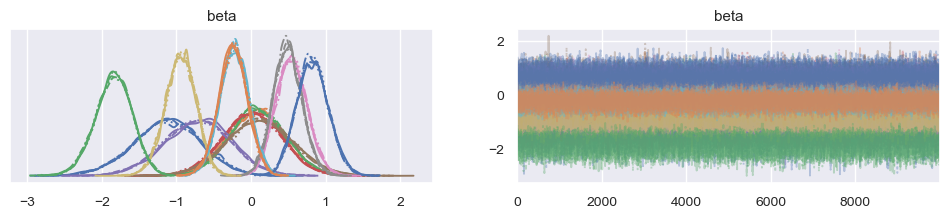

In [22]:
# Sample
with model:
    start = pm.find_MAP()
    opt = pm.HamiltonianMC(beta)
    trace = pm.sample(10000, opt, start=start,
                      return_inferencedata=True, random_seed=SEED)
    
# Trace plot
pm.traceplot(trace)

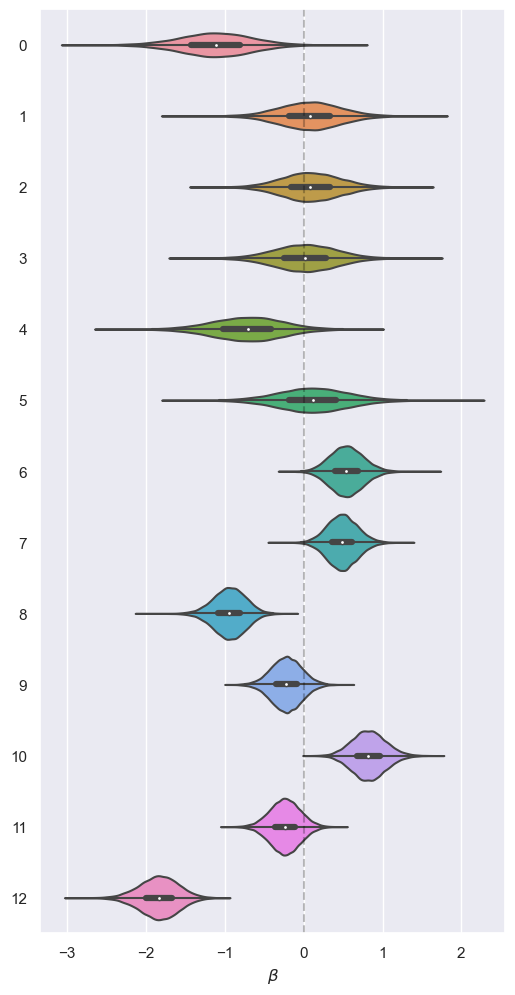

In [27]:
# Extract posterior samples of beta
trace_beta = trace.posterior['beta'].values.reshape(-1, NUM_VARS)
beta_names = ['intercept'] + bin_names[:-1] + quant_names + ['sex_x_smoking']

# Violin plot with seaborn
sns.set(rc={'figure.figsize':(6, 12)})
ax = sns.violinplot(data=trace_beta, orient='h')
ax.set(xlabel=r'$\beta$')
# ax.set_yticklabels(beta_names)
plt.axvline(0., linestyle='--', color='black', alpha=.25)

Text(0, 0.5, 'Frequency')

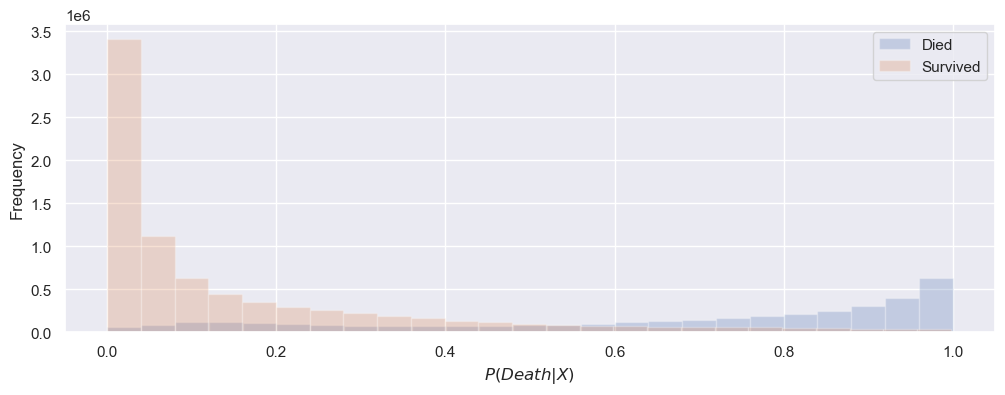

In [25]:
# Compute logit and probabilities from the posterior samples
post_logit = np.matmul(X, trace_beta.T)
post_p = 1 / (1 + np.exp(-post_logit))

# Plot
sns.set(rc={'figure.figsize':(12, 4)})
plt.hist(post_p[Y == 1,:].flatten(), alpha=.25, label='Died', bins=25)
plt.hist(post_p[Y == 0,:].flatten(), alpha=.25, label='Survived', bins=25)
plt.legend()
plt.xlabel(r'$P(Death|X)$')
plt.ylabel('Frequency')

In [26]:
# Flag observation w/ posterior prob > .01 that P(Death) > 0.5
acc, sens, spec = [], [], []
for p in (.01,.25,.5,.75,.99):
    pred = np.mean(post_p > .5, axis=1) > p
    tn, fp, fn, tp = confusion_matrix(Y, pred.astype(np.int16)).ravel()
    acc.append((tp + tn) / (tn + fp + fn + tp))
    sens.append(tp / (tp + fn))
    spec.append(tn / (tn + fp))
    
results = {'accuracy': acc, 'sensitivity': sens, 'specificity': spec}
results_df = pd.DataFrame(results, index=(.01,.25,.5,.75,.99))
results_df.index.name = 'cutoff'
results_df

,accuracy,sensitivity,specificity
cutoff,,,
0.01,0.772575,0.864583,0.729064
0.25,0.842809,0.760417,0.881773
0.50,0.869565,0.750000,0.926108
0.75,0.859532,0.687500,0.940887
0.99,0.795987,0.416667,0.975369
